In [1]:
from collections import defaultdict
import json
import os
import evaluate
import pandas as pd

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
def get_image_id(composit_image_id):
    composit_image_id = composit_image_id.split('_')
    if len(composit_image_id) > 2:
        image_id = composit_image_id[-2]
    else:
        image_id = composit_image_id[-1]
    return image_id

def get_split(composit_image_id):
    composit_image_id = composit_image_id.split('_')
    if len(composit_image_id) > 2:
        composit_split = composit_image_id[:-2]
    else:
        composit_split = composit_image_id[:-1]
    
    split = '_'.join(composit_split)
    return split

def group_results(raw_results):
    results = {}
    for element in raw_results:
        image_id = get_image_id(element['image_id'])
        split = get_split(element['image_id'])
        results[image_id] = element['caption']
    return results

In [3]:
import re

def pre_caption(caption, max_words=0):
    caption = re.sub(
        r"([.!\"()*#:;~])",
        ' ',
        caption.lower(),
    )
    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n')
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if max_words and len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])

    return caption

def load_testsets(path_text_data, list_skills=None):
    list_skills = list_skills if list_skills else []

    test_datasets = {'all' : pd.read_csv(path_text_data + 'Caption_all.tsv', sep='\t')}
    test_datasets.update({
        'test_%s' %skill : pd.read_csv(path_text_data + 'Caption_testing_%s.tsv'%skill, sep='\t') 
        for skill in list_skills if os.path.isfile(path_text_data + 'Caption_testing_%s.tsv'%skill)})
    test_datasets['test'] = test_datasets['all'][test_datasets['all'].split == 'test']
    test_datasets['val'] = test_datasets['all'][test_datasets['all'].split == 'val']
    del test_datasets['all']

    for split, dataset in test_datasets.items():
        dataset['caption'] = dataset['caption'].apply(pre_caption)
        dataset['image_id'] = dataset['image_ID'].astype(str)

    for split in test_datasets:
        test_datasets[split] = test_datasets[split][['image_id','caption']]

    return test_datasets

def to_grouped_dict(dataset):
    dict_dataset = dataset.to_dict(orient='records')
    grouped_dataset = defaultdict(list)
    for element in dict_dataset:
        grouped_dataset[element['image_id']].append(element['caption'])

    return grouped_dataset

def build_lists_for_evaluation(results, test_dataset, return_image_id=True):
    predictions = []
    references = []
    image_ids = list(test_dataset.keys())
    for image_id in image_ids:
        predictions.append(results[image_id])
        references.append(test_dataset[image_id])
    if return_image_id:
        return image_ids, predictions, references
    return predictions, references

### Load Test Sets

In [4]:
path_text_data = './data/'
list_skills = ['color', 'counting', 'gender']
test_datasets_dfs = load_testsets(path_text_data, list_skills=list_skills)
test_datasets_dfs['test'].head()

,image_id,caption
125,1007129816,the man with pierced ears is wearing glasses a...
126,1007129816,a man with glasses is wearing a beer can croch...
127,1007129816,a man with gauges and glasses is wearing a bli...
128,1007129816,a man in an orange hat starring at something
129,1007129816,a man wears an orange hat and glasses


In [5]:
list(test_datasets_dfs.keys())

['test_color', 'test_counting', 'test_gender', 'test', 'val']

In [6]:
test_datasets = {}
for split in test_datasets_dfs:
    test_datasets[split] = to_grouped_dict(test_datasets_dfs[split])

In [7]:
(list(test_datasets['test'].keys())[:5],
 list(test_datasets['test'].values())[:5])

(['1007129816', '1009434119', '101362133', '102617084', '10287332'],
 [['the man with pierced ears is wearing glasses and an orange hat',
   'a man with glasses is wearing a beer can crocheted hat',
   'a man with gauges and glasses is wearing a blitz hat',
   'a man in an orange hat starring at something',
   'a man wears an orange hat and glasses'],
  ['a black and white dog is running in a grassy garden surrounded by a white fence',
   'a boston terrier is running on lush green grass in front of a white fence',
   'a black and white dog is running through the grass',
   'a dog runs on the green grass near a wooden fence',
   'a boston terrier is running in the grass'],
  ['a young female student performing a downward kick to break a board held by her karate instructor',
   'girl about to kick a piece of wood in half while karate instructor holds it',
   'a girl kicking a stick that a man is holding in tae kwon do class',
   'a girl in karate uniform breaking a stick with a front kic

### Load Model Results

In [8]:
from tqdm.auto import trange, tqdm
from pathlib import Path
from nltk.translate.meteor_score import meteor_score
import numpy as np
cap_metrics = evaluate.combine(['bleu', 'rouge'])

def compute_metrics(predictions, references):
    metrics = cap_metrics.compute(predictions=predictions, references=references)
    for i in range(4):
        metrics[f'bleu{i+1}'] = metrics['precisions'][i]
    metrics['meteor'] = np.mean([meteor_score(hypothesis=p, references=rs) for p, rs in zip(predictions, references)])
    return metrics

def bold(text):
    BOLD = '\033[1m'
    END = '\033[0m'
    return BOLD + text + END

In [10]:
base_dir = 'BLIP/output/'
results_dir = 'outputs/results'
exp_names = [
    str(dir_.stem) for dir_ in Path(base_dir).glob('*') if str(dir_.stem) not in ['saved_exps', '.gitignore']]

In [75]:
print('{:40.40s}: {:40.40s}'.format('Modelo Base', 'caption_base_flickr'))
print()
print('{:40.40s}: {:40.40s}'.format('Modelo Andrés Color', 'caption_flickr_augmented_c'))
print('{:40.40s}: {:40.40s}'.format('Modelo Andrés Counting', 'caption_flickr_augmented_counting'))
print('{:40.40s}: {:40.40s}'.format('Modelo Andrés Gender', 'caption_augmented_flickr'))
print('{:40.40s}: {:40.40s}'.format('Modelo Andrés Color + Gender', 'caption_flickr_augmented_c+g'))
print('{:40.40s}: {:40.40s}'.format('Modelo Andrés Color + Counting', 'caption_flickr_augmented_color+counting'))
print('{:40.40s}: {:40.40s}'.format('Modelo Andrés Counting + Gender', 'caption_flickr_augmented_counting+gender'))
print('{:40.40s}: {:40.40s}'.format('Modelo Andrés Color + Counting + Gender', 'caption_flickr_augmented_color+counting+gender'))
print()
print('{:40.40s}: {:40.40s}'.format('Modelo Carlos Color', 'caption_flickr_inpaiting_color'))
print('{:40.40s}: {:40.40s}'.format('Modelo Carlos Counting', 'caption_flickr_inpaiting_counting'))
print('{:40.40s}: {:40.40s}'.format('Modelo Carlos Gender', 'caption_flickr_inpaiting_gender'))
print('{:40.40s}: {:40.40s}'.format('Modelo Carlos Color + Gender', 'caption_flickr_inpaiting_color+counting'))
print('{:40.40s}: {:40.40s}'.format('Modelo Carlos Color + Counting', 'caption_flickr_inpaiting_color+gender'))
print('{:40.40s}: {:40.40s}'.format('Modelo Carlos Counting + Gender', 'caption_flickr_inpaiting_counting+gender'))
print('{:40.40s}: {:40.40s}'.format('Modelo Carlos Color + Counting + Gender', 'caption_flickr_inpaiting_color+counting+gender'))

Modelo Base                             : caption_base_flickr                     

Modelo Andrés Color                     : caption_flickr_augmented_c              
Modelo Andrés Counting                  : caption_flickr_augmented_counting       
Modelo Andrés Gender                    : caption_augmented_flickr                
Modelo Andrés Color + Gender            : caption_flickr_augmented_c+g            
Modelo Andrés Color + Counting          : caption_flickr_augmented_color+counting 
Modelo Andrés Counting + Gender         : caption_flickr_augmented_counting+gender
Modelo Andrés Color + Counting + Gender : caption_flickr_augmented_color+counting+

Modelo Carlos Color                     : caption_flickr_inpaiting_color          
Modelo Carlos Counting                  : caption_flickr_inpaiting_counting       
Modelo Carlos Gender                    : caption_flickr_inpaiting_gender         
Modelo Carlos Color + Gender            : caption_flickr_inpaiting_color+counting 
Mo

In [47]:
exp_name_base = 'caption_base_flickr'
exp_name = 'caption_flickr_augmented_color+counting+gender'

test_set_name = 'test_counting'

In [48]:
import json

with open(f'{results_dir}/{exp_name_base}.json') as fp:
    base_results = json.load(fp)
    
with open(f'{results_dir}/{exp_name}.json') as fp:
    experiment_results = json.load(fp)

In [59]:
(list(base_results.keys()),
 list(base_results['test'].keys())[:5],
 base_results['test']['1007129816'][0])

(['test_color', 'test_counting', 'test_gender', 'test'],
 ['1007129816', '1009434119', '101362133', '102617084', '10287332'],
 {'prediction': 'a man wearing a hat made of beer bottles',
  'references': ['the man with pierced ears is wearing glasses and an orange hat',
   'a man with glasses is wearing a beer can crocheted hat',
   'a man with gauges and glasses is wearing a blitz hat',
   'a man in an orange hat starring at something',
   'a man wears an orange hat and glasses'],
  'metrics': {'bleu': 0.0,
   'precisions': [0.6666666666666666, 0.25, 0.0, 0.0],
   'brevity_penalty': 1.0,
   'length_ratio': 1.125,
   'translation_length': 9,
   'reference_length': 8,
   'rouge1': 0.6,
   'rouge2': 0.22222222222222224,
   'rougeL': 0.5,
   'rougeLsum': 0.5}})

### Order Elements by increas in bleu 4

In [62]:
base_results_for_test = base_results[test_set_name]
results_for_test = experiment_results[test_set_name]

bleu_4_fn = lambda r: r[0]['metrics']['precisions'][3]
most_improved_fn = lambda iid: (bleu_4_fn(results_for_test[iid]) - bleu_4_fn(base_results_for_test[iid]))

most_improved_ids = sorted(list(results_for_test.keys()), key=most_improved_fn, reverse=True)

In [71]:
for iid in most_improved_ids[:10]:
    print('Image Id  :', iid)
    print('Bleu4 Diff: {:.3f}'.format(most_improved_fn(iid)), end='\n\n')

Image Id  : 3246281818
Bleu4 Diff: 0.571

Image Id  : 12252043
Bleu4 Diff: 0.556

Image Id  : 6927762908
Bleu4 Diff: 0.429

Image Id  : 136693281
Bleu4 Diff: 0.400

Image Id  : 2268207503
Bleu4 Diff: 0.400

Image Id  : 509123893
Bleu4 Diff: 0.400

Image Id  : 2169788484
Bleu4 Diff: 0.385

Image Id  : 2830561413
Bleu4 Diff: 0.333

Image Id  : 5829317322
Bleu4 Diff: 0.273

Image Id  : 6489895665
Bleu4 Diff: 0.273



In [ ]:
from IPython.display import Image

index_to_inspect = 0

prediction (0.00): a black dog and two white dogs in the snow
base       (0.50): four dogs are standing in the snow

references:
two large black dogs, one small black dog, and one large white dog are standing in some snow
two black dogs, a black puppy, and a white dog in the snow
three black dogs and a white dog are standing in the snow
four dogs stand in the snow


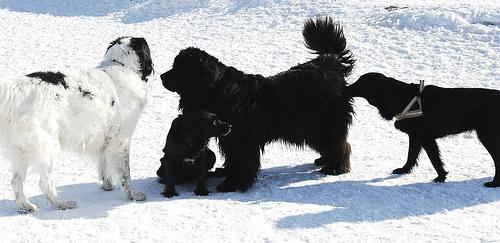

In [17]:
image_id = most_improved_ids[index_to_inspect]

prediction = results_for_test[image_id][0]
base_prediction = base_results_for_test[image_id][0]

from IPython.display import Image

print(f'{bold("prediction")} ({prediction["metrics"]["precisions"][3]:.2f}): {prediction["prediction"]}')
print(f'{bold("base")}       ({base_prediction["metrics"]["precisions"][3]:.2f}): {base_prediction["prediction"]}')

print('\n' + bold('references:'))
print('\n'.join(prediction['references']))

Image(filename=f'/workspace1/fidelrio/flickr30k/imgs/{image_id}.jpg') 

### Sample Better than baseline predictions

In [72]:
import random
sampled = random.sample(list(
    filter(lambda x: x[1] > 0, map(lambda x: (x, most_improved_fn(x)), results_for_test.keys()))), k=20)
sampled_image_ids, _ = zip(*sampled)

sampled_image_ids

('4954827712',
 '3970114165',
 '405556084',
 '273603643',
 '4817447781',
 '4664359066',
 '2511798599',
 '3246281818',
 '2830561413',
 '3701291852',
 '464340358',
 '5501939468',
 '77587237',
 '3715669736',
 '2565302802',
 '16626851',
 '5730226613',
 '110671448',
 '3086526292',
 '2724485630')

In [73]:
index_to_inspect = 0

prediction (0.20): two people are walking in the dirt in front of a large building
base       (0.11): a group of people are walking in front of a large building

references:
two people walking on dirt in front of a very large building
two women are walking in dirt outside a large building


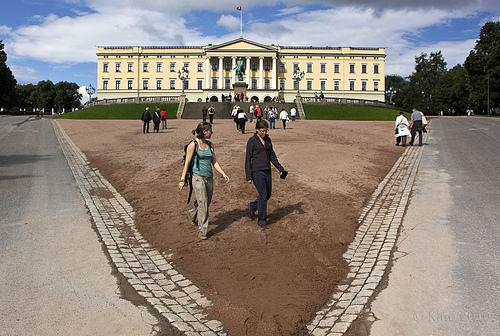

In [74]:
image_id = sampled_image_ids[index_to_inspect]

prediction = results_for_test[image_id][0]
base_prediction = base_results_for_test[image_id][0]

print(f'{bold("prediction")} ({prediction["metrics"]["precisions"][3]:.2f}): {prediction["prediction"]}')
print(f'{bold("base")}       ({base_prediction["metrics"]["precisions"][3]:.2f}): {base_prediction["prediction"]}')

print('\n' + bold('references:'))
print('\n'.join(prediction['references']))

index_to_inspect += 1 

Image(filename=f'/workspace1/fidelrio/flickr30k/imgs/{image_id}.jpg') 